# Machine Learning Housing Corporation

In [1]:
import os, sys
sys.path.append('helpers/')
import MPL_header #load common MPL imports 
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline

In [2]:
import sklearn
import numpy as np
import pandas as pd
np.random.seed(12345)

In [3]:
# check loaded mdules
%who_ls

['MPL_header', 'np', 'os', 'pd', 'plt', 'sklearn', 'sys']

### Use helper function to download data

In [4]:
# %run helpers/fetch_tar_data_pd.py --fetch --url='https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz'

In [5]:
def load_housing_data(path='/Users/gleb/software/ML_GPU/DATA/housing.csv'):
    return pd.read_csv(path)

In [6]:
housing=load_housing_data()
housing.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
print("Missing vales:", housing.isnull().values.any())

Missing vales: True


In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [10]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

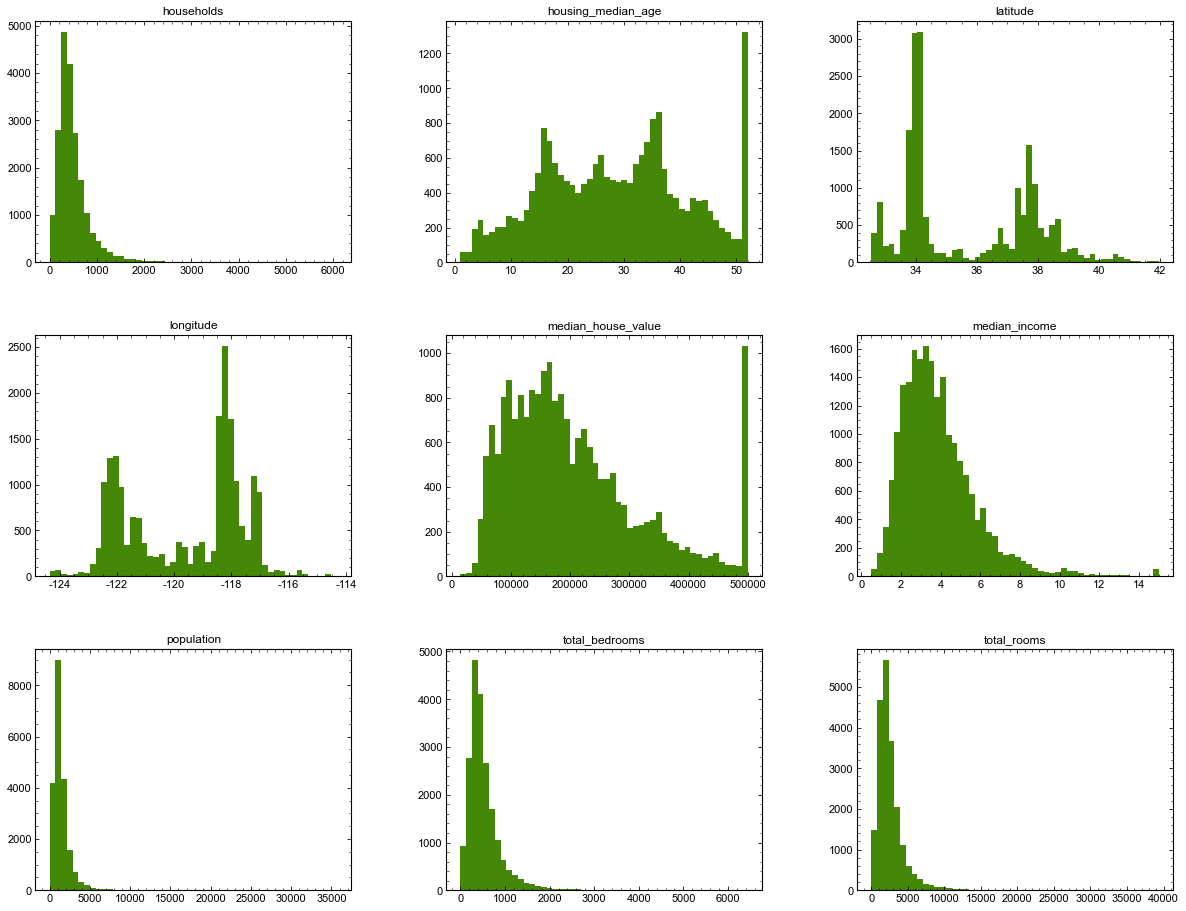

In [11]:
ax=housing.hist(bins=50, figsize=(20,15), log=False)
ax[0][0].get_figure().savefig('fig/housing_overview.png', bbox_inches='tight')

In [12]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = split_train_test(housing, 0.2)

### This is no good, even with constant seed...DS can be updated...Use hashing!

In [14]:
# from zlib import crc32
import hashlib

In [15]:
# def test_set_check(identifier, test_ratio):
#     return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    #open_ssl->digest[0,256]
    #return T/F if less than 256*ratio
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio


In [16]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    #T/F mask
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    #~reverses the boolean 
    return data.loc[~in_test_set], data.loc[in_test_set]

In [17]:
# if no index, add one!
# housing_with_id = housing.reset_index()

In [18]:
# train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

### Adding index can be problematic, if deleting data and new data needs to be appended to the end...Alternative, make new ID feaure

In [19]:
#add new column 'id'
# housing["id"] = housing["longitude"] * 1000 + housing["latitude"]
# train_set, test_set = split_train_test_by_id(housing, 0.2, "id")

### Best way to use sikit func.

In [20]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=123)

### Need startas (more represenative sample of population);  Use income to create new attribute

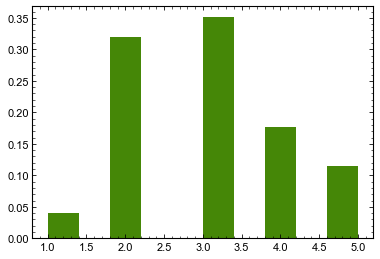

In [21]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
weights = np.ones_like(housing["income_cat"])/float(len(housing["income_cat"]))
plt.hist(housing["income_cat"], weights=weights);

### Stratified sampling based on the income category

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

In [23]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

In [24]:
# split.split?

In [25]:
#single split, .split() = Generate indices to split data into training and test set.
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index] 
    strat_test_set = housing.loc[test_index]

In [26]:
strat_train_set["income_cat"].value_counts()/ len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

### The error from non-stratifed data is larger

In [27]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] =  abs( compare_props["Random"] / compare_props["Overall"] * 100 - 100 )
compare_props["Strat. %error"] =  abs( compare_props["Stratified"] / compare_props["Overall"] * 100 - 100 )

In [28]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,0.243309
2,0.318847,0.318798,0.324370,1.732260,0.015195
3,0.350581,0.350533,0.358527,2.266446,0.013820
4,0.176308,0.176357,0.167393,5.056334,0.027480
5,0.114438,0.114583,0.109496,4.318374,0.127011


Now you should remove the income_cat attribute so the data is back to its original state

In [29]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [30]:
housing = strat_train_set.copy()

In [31]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
11587,-118.02,33.78,28.0,3375.0,559.0,1754.0,554.0,5.5446,228900.0,<1H OCEAN
12635,-121.47,38.48,25.0,2969.0,551.0,1745.0,487.0,2.6382,76200.0,INLAND
8021,-118.11,33.84,36.0,1756.0,297.0,798.0,287.0,5.5581,218300.0,<1H OCEAN
19326,-122.94,38.50,46.0,2280.0,492.0,807.0,366.0,2.6316,117000.0,<1H OCEAN
9052,-118.12,34.71,46.0,40.0,10.0,14.0,7.0,1.1250,225000.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
13975,-116.76,34.23,10.0,4374.0,989.0,1020.0,376.0,2.6071,89000.0,INLAND
1454,-121.96,37.96,28.0,1838.0,273.0,899.0,270.0,5.2145,229200.0,INLAND
1120,-121.59,39.77,24.0,1535.0,276.0,664.0,273.0,2.3068,97300.0,INLAND
9762,-121.73,36.50,27.0,3184.0,520.0,1121.0,493.0,5.6383,377000.0,<1H OCEAN


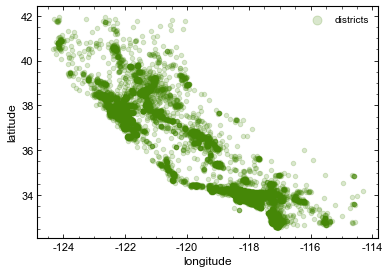

In [32]:
fig, ax = plt.subplots()
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, ax=ax, label='districts');
ax.legend(scatterpoints=1, markerscale=2);

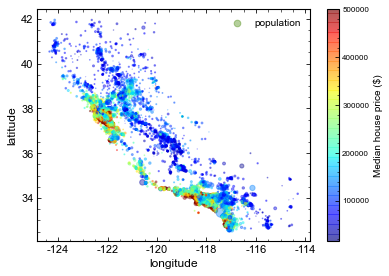

In [33]:
# s = radius, c=colour
# generate fig for saving
# !! and ax, to pass to prserve x-axis (MPL/Jlab bug: https://github.com/pandas-dev/pandas/issues/10611)
fig, ax = plt.subplots()
ax=housing.plot(kind='scatter', x='longitude', y='latitude',  alpha=0.4, s=housing['population']/400, 
             c='median_house_value', cmap=plt.get_cmap('jet'), ax=ax, label='population');
#cabar is the 2nd axis
fig.get_axes()[1].set_ylabel('Median house price ($)', fontsize=10)
fig.get_axes()[1].tick_params(labelsize=8)
fig.savefig('fig/CA.png', bbox_inches='tight')

In [34]:
corr_matrix=housing.corr()

### how much each attribute correlates with the median house value

In [35]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690077
total_rooms           0.131453
housing_median_age    0.099620
households            0.064110
total_bedrooms        0.048565
population           -0.023790
longitude            -0.047697
latitude             -0.144086
Name: median_house_value, dtype: float64

In [36]:
from pandas.plotting import scatter_matrix

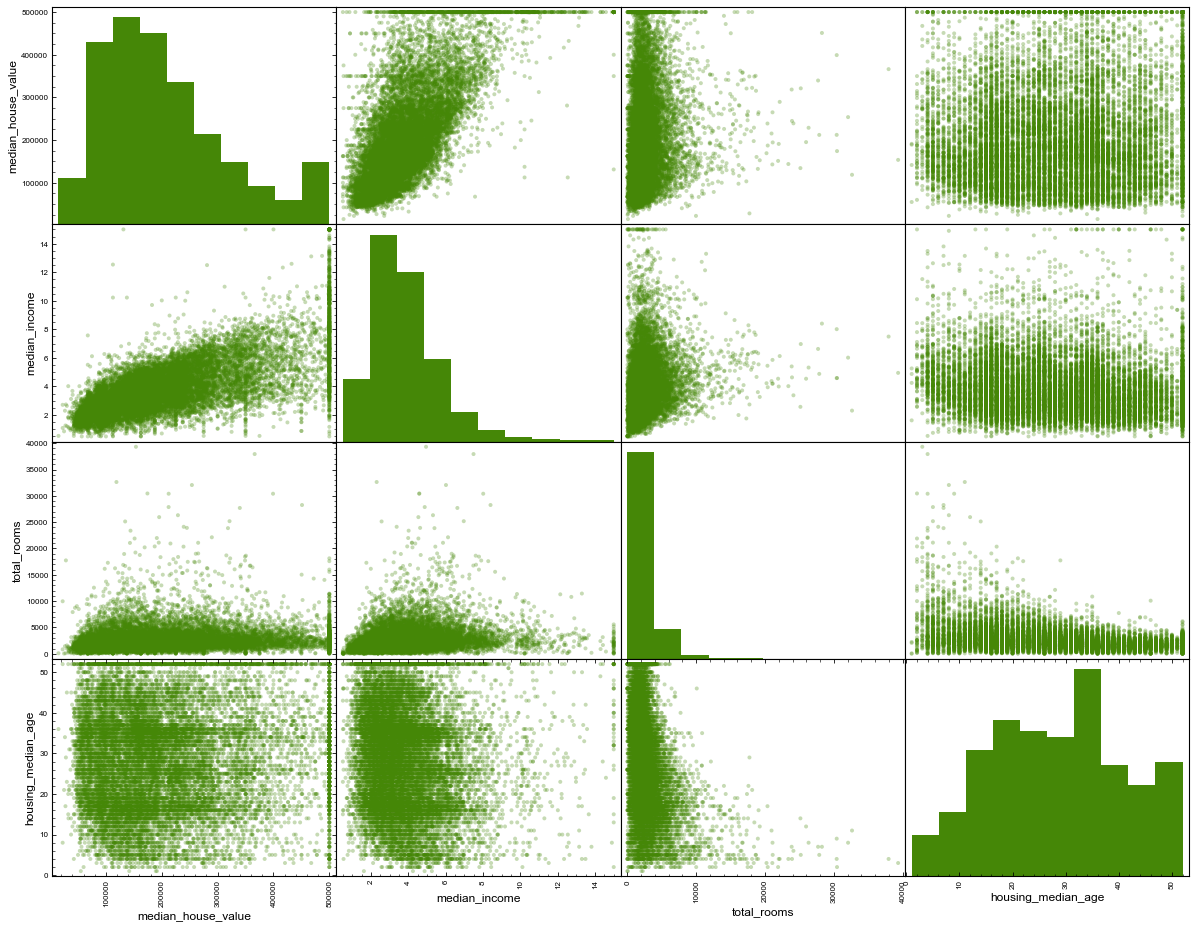

In [42]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
ax=scatter_matrix(housing[attributes], figsize=(20,15), alpha=0.3);
ax[0][0].get_figure().savefig('fig/cor.png', bbox_inches='tight')

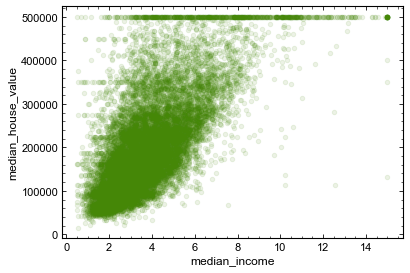

In [38]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1);

### Creating new attributes

In [39]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [40]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690077
rooms_per_household         0.153156
total_rooms                 0.131453
housing_median_age          0.099620
households                  0.064110
total_bedrooms              0.048565
population_per_household   -0.022425
population                 -0.023790
longitude                  -0.047697
latitude                   -0.144086
bedrooms_per_room          -0.261785
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms